In [39]:
import glob
import os
import xarray as xr
import contextily as ctx
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
drop_variables=['siglay','siglev', 'sensible_heat_flux','latent_heat_flux', 'long_wave']
ds =  xr.open_mfdataset('/home/abolmaal/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202302/Fvcome_houron_estuary_2023*.nc', 
                     concat_dim="time", combine="nested",
                       data_vars='minimal', coords='minimal', compat='override', decode_times=False, 
                     drop_variables=drop_variables, engine='netcdf4')

In [45]:
time = ds2.variables['Times'][:]
time.values[:]
# print the length of the time array


array([b'2023-03-01T12:00:00.000000'], dtype='|S26')

In [41]:
drop_variables=['siglay','siglev', 'sensible_heat_flux','latent_heat_flux', 'long_wave']


In [44]:
# print the time variable
print(ds2.Times)

<xarray.DataArray 'Times' (time: 1)>
[1 values with dtype=|S26]
Coordinates:
  * time     (time) float32 1.886e+03
Attributes:
    time_zone:  UTC


In [51]:
ds2 = xr.open_dataset('/home/abolmaal/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202303/Fvcome_houron_estuary_20230331.t18z.nc', 
                     decode_times=False, drop_variables=drop_variables)
time2 = ds2.variables['Times'][:]
time2.values[:]


array([b'2023-03-31T12:00:00.000000'], dtype='|S26')

In [49]:
time2

<xarray.Variable (time: 1)>
array([b'2023-02-28T19:00:00.000000'], dtype='|S26')
Attributes:
    time_zone:  UTC

In [ ]:
# plot U adn V velocity
u= ds2.u.isel(siglay=0, time=0)
v= ds2.v.isel(siglay=0, time=0)
u.plot()
v.plot()

# 1- Required imports

In [2]:
# Required imports
from collections import namedtuple
import numpy as np
import datetime
from netCDF4 import Dataset
import configparser
from matplotlib import pyplot as plt
from cftime import num2pydate
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands
from matplotlib.colors import LinearSegmentedColormap, LogNorm

In [3]:
import os
#data_dir = '/home/samin/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202301'.format(os.environ['HOME'])
data_dir='/home/abolmaal/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202303'.format(os.environ['HOME']) 
# Create run directory
cwd = os.getcwd()
# Create run directory
simulation_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# 2-Create Grid metrics

In [4]:
from pylag.grid_metrics import create_fvcom_grid_metrics_file

# An example FVCOM output file
#fvcom_file_name = '/home/samin/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202301/Fvcome_houron_estuary_20230101.t00z.nc'
fvcom_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202303/Fvcome_houron_estuary_20230331.t18z.nc'

# The file listing the location of open boundary nodes
#obc_file_name = '/home/samin/data/FVCOME_OUTPUT/fvcom_tamar_estuary_obc.dat'
obc_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/obc.dat'
# The name of the output file
#grid_metrics_file_name = f'{input_dir}/grid_metrics_huron2.nc'
#grid_metrics_file_name = f'{input_dir}/grid_metrics_huron_senseflux.nc'
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'

# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name = obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc
INFO - detected longitudes greater than 180.0 in variable lon. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - detected longitudes greater than 180.0 in variable lonc. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.

Calculating element areas ... done
Grid has 51110 nodes on the open boundary


# 3-Read the bathymetry file

In [ ]:
# # Create initial position file
# from pylag.processing.input import create_initial_positions_file_multi_group
# import pandas as pd
# #test_dir = f"{input_dir}/initial_position"
# initial_position_file = f"{input_dir}/initial_position/GLB_Bdry_buff10km_dem_fil_flowacc_con300_raster_lh_shore_NOAA70k_intersection_table.dat"
# file_name = f"{input_dir}/initial_positions/initial_positions_multi_group.dat"
# # Read the file into a pandas DataFrame and skip the first line
# df = pd.read_csv(initial_position_file, sep = ' ',skiprows=1)
# group_id = df.iloc[:,0]
# lons = df.iloc[:,1]
# lats= df.iloc[:,2]


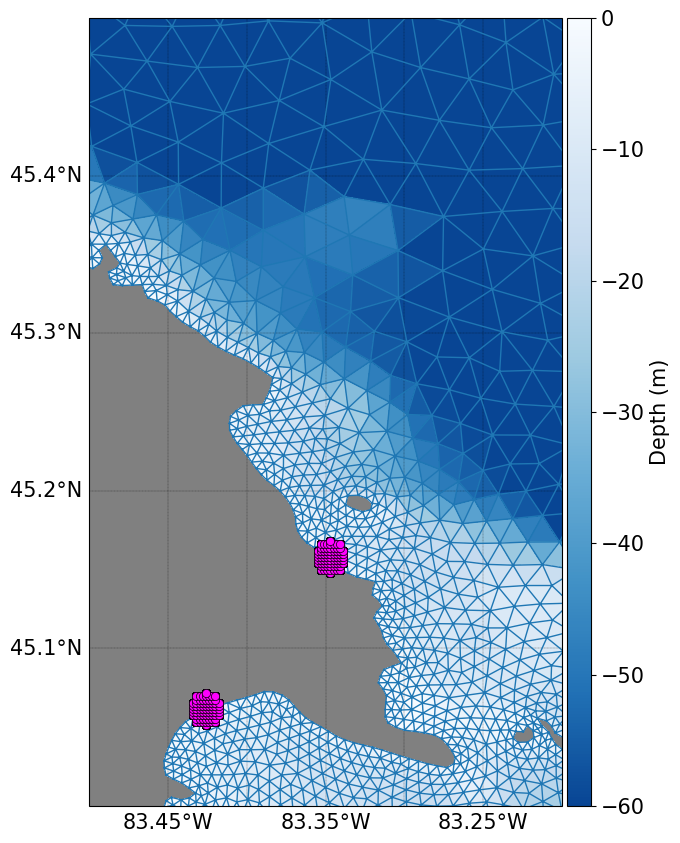

In [6]:
# Convert utm coords to degrees
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap

# lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
#                              surface_release_zone.get_northings(),
#                              epsg_code=epsg_code)
# read initial poision file from input directory
import pandas as pd
# Specify the file path of the initial position file
#initial_position_file = f"{input_dir}/initial_position/WatershedPourPoints_LH_multigroup_rounded3.dat"
initial_position_file = f"{input_dir}/initial_position/WatershedPourPoints_LH_multigroup_4.dat"

#initial_position_file = f"{input_dir}/initial_position/watershed_initial_positions_huron.dat"
# Read the file into a pandas DataFrame and skip the first line
df = pd.read_csv(initial_position_file, sep = ' ',skiprows=1)
group_id = df.iloc[:,0]
lons = df.iloc[:,1] 
lats= df.iloc[:,2]

# Create figure
font_size = 15
cmap = colourmap('h_r')
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(),
                      font_size=font_size, bg_color='gray')
#Grid metrics file name
grid_metrics_file_name = f"{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc"
# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
#extents = np.array([-84.10,-84.20, 45.58,45.65], dtype=float)
#extensts = np.array([-84,-81.3, 43,46], dtype=float)
#Lake Huron Ausable Point
#extents = np.array([275, 277.69, 43, 46.3], dtype=float)
extents = np.array([276.5, 276.8, 45, 45.5], dtype=float)

ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=blue_cmap_reversed)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=35, color='fuchsia', edgecolors='black', linewidth=0.5, zorder=10)
# add x and y labels

#ax.set_title('Initial Positions along Lake Huron', loc='center', pad=20)
# save the initial positions figure
#plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/initial_positions_LakeHuron_multigrouppoin_eachwatershed.jpeg', dpi=300)
#plt.savefig(f"{input_dir}/initial_position/release_zone_LakeHuron_multigrouppoin_eachwatershed.png") 

# 4-Creating Run configuration

In [62]:
import configparser
#config_file_name = '/home/samin/data/FVCOME_OUTPUT/confings/huron_senseflux.cfg'
config_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Nutrientflux_Project/Particle_Tracking/config_files/huron_senseflux_20230103_Seasonal_mortality.cfg'


cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with FVCOM in cartesian coordinates
print('Model name: {}'.format(cf.get('OCEAN_DATA', 'name')))
print('Coordinate system: {}'.format(cf.get('SIMULATION', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_DATA', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_DATA', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_DATA', 'data_file_stem')))
      
# Do an advection only run using a RK$ intergration scheme 
print('Numerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))

Start time: 2023-03-01  00:00:00
End time: 2023-03-30  00:00:00
Time direction: forward
Number of particle releases: 1
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: FVCOM
Coordinate system: geographic
Data directory: /home/abolmaal/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202303/
Path to grid metrics file: /home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc
File name stem of input files: Fvcome_houron_estuary
Numerical method: standard
Iterative method: Adv_RK4_3D


# 5-Setting Mortality

If you use the following config file huron_senseflux_20230103_Seasonal_mortality.cfg, you don't need to run section 5. it is here for demonstration and showing how mortality works.

In [6]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from configparser import ConfigParser

import pylag.random as random
from pylag.data_reader import DataReader
from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.mortality import get_mortality_calculator
from pylag.processing.plot import create_figure

# Ensure inline plotting
%matplotlib inline

# Parameters
seconds_per_day = 86400.

# Seed the random number generator
random.seed(10)

# Create the config
#cf.add_section('NUMERICS')
cf.add_section('BIO_MODEL')
cf.add_section('FIXED_TIME_MORTALITY_CALCULATOR')
cf.add_section('PROBABILISTIC_MORTALITY_CALCULATOR')
# We need a data reader to pass to the mortality calculator. It
# can be used to draw out environmental variables (e.g. temperature)
# that affect mortality. In both cases below, it isn't used, so we
# use the base class.
data_reader = DataReader()

# Set time stepping params
n_particles = 1000
simulation_duration_in_days = 30.0
time_step = 100
time_end = simulation_duration_in_days * seconds_per_day
times = np.arange(0.0, time_end, time_step)

In [7]:
 #Helper function in which the model is run and mortality computed
def run(config, n_particles=1000):
    """ Run the model to compute mortality through time """

    # Create the mortality calculator
    mortality_calculator = get_mortality_calculator(config)

    # Create the living particle seed
    particle_set = []
    for i in range(n_particles):
        # Instantiate a new particle
        particle = ParticleSmartPtr(age=0.0, is_alive=True)

        # Initialise particle mortality parameters
        mortality_calculator.set_initial_particle_properties_wrapper(particle)

        # Append it to the particle set
        particle_set.append(particle)

    # Store the number of living particles in a list
    n_alive_arr = []

    # Run the model
    n_alive = n_particles
    for t in times:
        n_alive_arr.append(n_alive)

        n_deaths = 0
        for particle in particle_set:
            if particle.is_alive:
                mortality_calculator.apply_wrapper(data_reader, t, particle)
                if particle.is_alive == False:
                    n_deaths += 1
            particle.set_age(t)

        n_alive -= n_deaths

    return n_alive_arr

## 5-1FixedTimeMortalityCalculater

In [8]:
# Specify a fixed time mortality calculator
cf.set('BIO_MODEL', 'mortality_calculator', 'fixed_time')

# 1) Fixed time scenario
# Sharp_2021 suggerst 10 days fpr N uptake in coastal wetlands
age_of_death_in_days = 10.
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'common_value')
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'common_value', str(age_of_death_in_days))
n_alive_common_value = run(cf)

In [9]:
# 2) Uniform Random 
minimum_bound = 8.
maximum_bound = 12.
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'uniform_random')
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'minimum_bound', str(minimum_bound))
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'maximum_bound', str(maximum_bound))
n_alive_uniform_random = run(cf)

In [10]:
# 2) Gaussian random
mean = 10.
standard_deviation = 1.
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'gaussian_random')
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'mean', str(mean))
cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'standard_deviation', str(standard_deviation))
n_alive_gaussian_random = run(cf)
# Set the bio time step
cf.set('NUMERICS', 'time_step_bio', str(time_step))

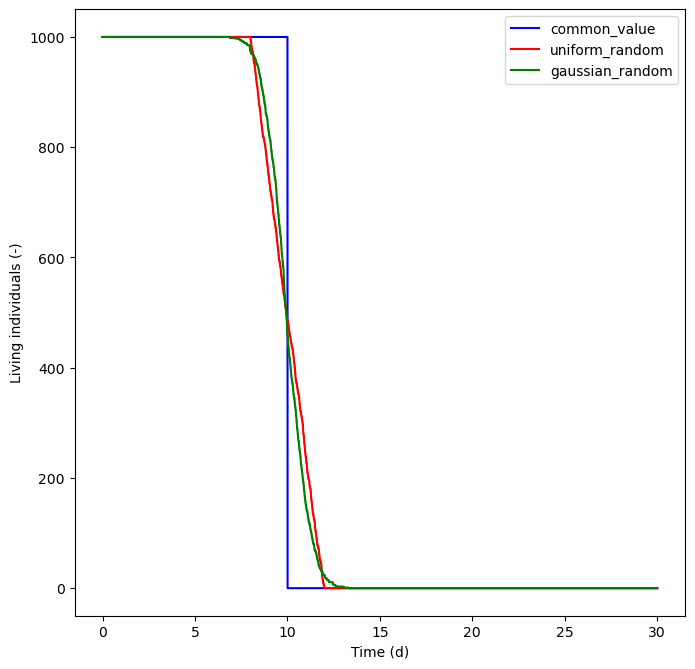

In [11]:
# Plot
font_size = 10
fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
plt.plot(times/seconds_per_day, n_alive_common_value, 'b', label='common_value')
plt.plot(times/seconds_per_day, n_alive_uniform_random, 'r', label='uniform_random')
plt.plot(times/seconds_per_day, n_alive_gaussian_random, 'g', label='gaussian_random')
# Set the bio time step
plt.ylabel('Living individuals (-)', fontsize=font_size)
plt.xlabel('Time (d)', fontsize=font_size)

# Add legend
plt.legend()

## 5-2ProabilisticMortalityCalculator

The mortality calculator kills particles at a rate 
, where 
 is a fixed mortality rate which is set in the run configuraiton file and 
 is the model time step for biological processes. The model computes a uniform random deviate in the range (0, 1). If the number is less than the computed death rate, the particle is killed. Below, we create a population of 
 individuals. We apply a death rate of 
 per day and use a time step of 
 seconds. The model is run forward for 
 days and the number of living individuals plotted as a function of time. The result is compared with a simple analytical solution of exponential decay

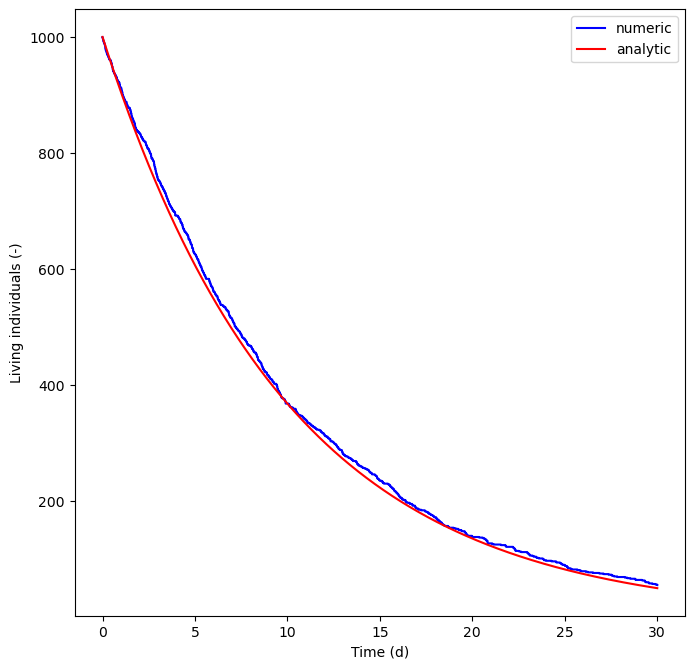

In [12]:

# Specify a probabilistic mortality calculator
cf.set('BIO_MODEL', 'mortality_calculator', 'probabilistic')

# Set the death rate - currently the same for all particles.
death_rate_per_day = 0.1
cf.set('PROBABILISTIC_MORTALITY_CALCULATOR', 'death_rate_per_day', str(death_rate_per_day))

# Set the bio time step
cf.set('NUMERICS', 'bio_time_step', str(time_step))

# Number of particles
n_particles = 1000

# Run the model
n_alive_numeric = run(cf, n_particles=n_particles)

# Compute the equivalent analytical solution
death_rate_per_second = death_rate_per_day / seconds_per_day
n_alive_analytic = n_particles * np.exp(-death_rate_per_second * times)

# Plot
font_size = 10
fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
plt.plot(times/seconds_per_day, n_alive_numeric, 'b', label='numeric')
plt.ylabel('Living individuals (-)', fontsize=font_size)
plt.xlabel('Time (d)', fontsize=font_size)

# Add equivalent analytical solution
plt.plot(times/seconds_per_day, n_alive_analytic, 'r', label='analytic')

# Add legend
plt.legend()

# 6-Run the model 

In [63]:
cf.set('OCEAN_DATA', 'data_dir', data_dir)
cf.set('OCEAN_DATA', 'grid_metrics_file', grid_metrics_file_name)
# Directory where the simulation outputs will be saved
out_dir = f"{simulation_dir}/output"
cf.set('GENERAL', 'out_dir', out_dir)

# Save a copy in the simulation directory
with open(f"{simulation_dir}/pylag.cfg", 'w') as config:
    cf.write(config)

In [64]:
# Change to the run directory
os.chdir(f"{simulation_dir}")
# Run the model
!{"python -m pylag.main -c pylag.cfg"}
# Return to the cwd
os.chdir(cwd)



Starting ensemble member 1 ...
Progress:
100% |###########################################|


# 7-Plotting the Data

Date 2023-01-01 06:00:00 not found in viewer.date


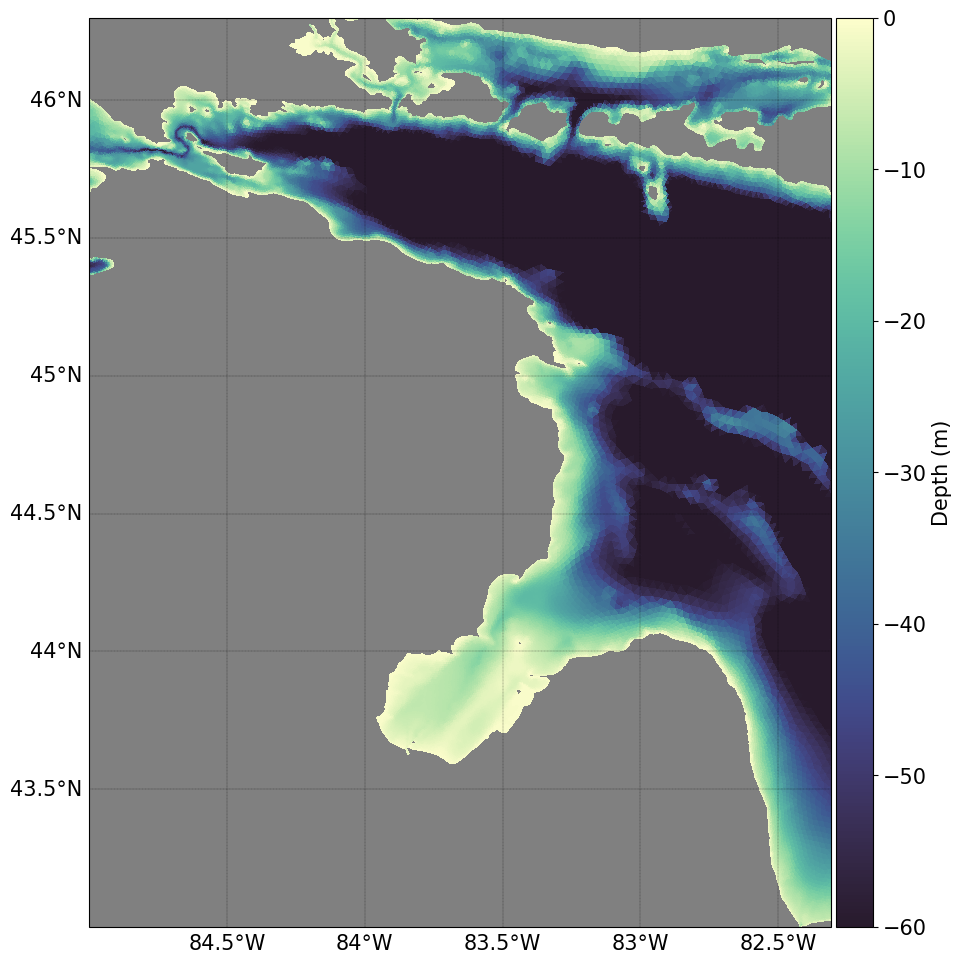

In [20]:
from datetime import timedelta
from pylag.processing.ncview import Viewer
from datetime import datetime
import gc
batch_size = 50

for file_name in sorted(filter (lambda x : x.endswith("nc"),os.listdir('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Mar/Mortality')),key= lambda x : int(x.split(".")[0].split("__")[1])):
    sample_name = file_name
    file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Mar/Mortality/' + file_name 
    time_of_flight = timedelta(hours=6)
    font_size = 15
    extents = np.array([275, 277.69, 43, 46.3], dtype=float)
    fig, ax = create_figure(figure_size=(30., 30.), projection=ccrs.PlateCarree(),
                            font_size=font_size, bg_color='gray')
    plotter = FVCOMPlotter(grid_metrics_file_name,
                           geographic_coords=True,
                           font_size=font_size)
    plotter.plot_field(ax, bathy, extents= extents, add_colour_bar=True, cb_label='Depth (m)',
                       vmin=-60., vmax=0., cmap=cmap)
    viewer = Viewer(file_name, time_rounding=25200)
    date = viewer.date[0] + time_of_flight
    if date in viewer.date.tolist():
        time_index = viewer.date.tolist().index(date)
    else:
        print(f"Date {date} not found in viewer.date")
        continue
    time_index = viewer.date.tolist().index(date)
    n_times = viewer.date[:time_index+1].shape[0]
    lons,lats = [viewer('longitude')[time_index,:].squeeze(), viewer('latitude')[time_index, :].squeeze()]
    ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='black')
    lons_paths, lats_paths = (viewer('longitude')[:time_index+1, :],
                                         viewer('latitude')[:time_index+1, :])
    
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=2, alpha=1, color='#0504aa')
    output_directory = '/home/abolmaa/data/FVCOME_OUTPUT/Simulations/Huron/results'
    output_file = os.path.join(output_directory, sample_name.split(".")[0] + ".png")
    plt.savefig(output_file, dpi=50)
    #plt.savefig(output_directory+sample_name.split(".")[0]+ ".png",dpi=50)
    plt.close(fig)

In [65]:
import os
import numpy as np
from datetime import timedelta, datetime
from pylag.processing.ncview import Viewer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gc

batch_size = 50
output_directory = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results'
os.makedirs(output_directory, exist_ok=True)

for file_name in sorted(filter(lambda x: x.endswith("nc"), os.listdir('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Mar/Mortality')), key=lambda x: int(x.split(".")[0].split("__")[1])):
    sample_name = file_name
    file_name = os.path.join('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Mar/Mortality', file_name)
    time_of_flight = timedelta(hours=24)
    font_size = 15
    extents = np.array([275.6, 276, 45.4, 45.59], dtype=float)

    fig, ax = create_figure(figure_size=(20., 20.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')
    
    # Assuming grid_metrics_file_name, bathy, and cmap are defined elsewhere
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=cmap)
    
    viewer = Viewer(file_name, time_rounding=25200)
    date = viewer.date[0] + time_of_flight
    if date in viewer.date.tolist():
        time_index = viewer.date.tolist().index(date)
    else:
        print(f"Date {date} not found in viewer.date")
        continue
    # Convert positions into lons/lats
    lons, lats = [viewer('longitude')[time_index, :].squeeze(), viewer('latitude')[time_index, :].squeeze()]
    
    # Plot particle final positions
    ax, scatter = plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='black')
    
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, :], viewer('latitude')[:time_index + 1, :])
    
    # Convert all pathline coordinates into lons/lats
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.5, alpha=1, color='#0504aa')
    
    output_file = os.path.join(output_directory, f"{sample_name.split('.')[0]}.png")
    plt.savefig(output_file, dpi=50)
    plt.close(fig)
    gc.collect()